In [8]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [2]:
def get_linkage_matrix(cov_matrix):
    """
    Step 1: Create the Hierarchical Cluster (Linkage Matrix).
    """
    # Convert Covariance to Correlation
    v = np.sqrt(np.diag(cov_matrix))
    outer_v = np.outer(v, v)
    corr = cov_matrix / outer_v
    corr[cov_matrix == 0] = 0
    
    # Convert Correlation to Distance
    # d = sqrt(2 * (1 - rho))
    dist = np.sqrt(2 * (1 - corr))
    
    # Squareform is needed for scipy linkage if input is a distance matrix
    # We take the upper triangle of distances
    from scipy.spatial.distance import squareform
    dist_array = squareform(dist, checks=False)
    
    # Compute Linkage (Ward's method minimizes variance within clusters)
    linkage_matrix = sch.linkage(dist_array, 'ward')
    return linkage_matrix

def get_quasi_diag(linkage_matrix):
    """
    Step 2: Sort the assets based on the hierarchy.
    Reorders the covariance matrix so similar assets are neighbors.
    """
    linkage_matrix = linkage_matrix.astype(int)
    sort_ix = pd.Series([linkage_matrix[-1, 0], linkage_matrix[-1, 1]])
    num_items = linkage_matrix[-1, 3] # Total number of original items
    
    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0] * 2, 2) # Create space
        df0 = sort_ix[sort_ix >= num_items] # Find clusters
        i = df0.index
        j = df0.values - num_items # Index into linkage matrix
        
        sort_ix[i] = linkage_matrix[j, 0] # Left child
        df0 = pd.Series(linkage_matrix[j, 1], index=i + 1) # Right child
        
        sort_ix = pd.concat([sort_ix, df0]) # Combine
        sort_ix = sort_ix.sort_index() # Re-sort
        sort_ix.index = range(sort_ix.shape[0]) # Re-index
        
    return sort_ix.tolist()

In [3]:
def get_cluster_var(cov, c_items):
    """
    Helper: Calculates the variance of a cluster of assets.
    """
    # Calculate the inverse variance weights for assets INSIDE this cluster
    # This is a local IVP (Inverse Volatility Portfolio)
    cov_slice = cov.loc[c_items, c_items]
    w = 1 / np.diag(cov_slice) # Inverse variance
    w = w / w.sum() # Normalize
    
    # The variance of the cluster is: w.T * Cov * w
    return np.dot(np.dot(w.T, cov_slice), w)

def get_rec_bisection(cov, sort_ix):
    """
    Step 3: Recursive Bisection.
    Allocates capital top-down based on cluster variance.
    """
    # Initialize weights to 1.0 for everyone
    w = pd.Series(1.0, index=sort_ix)
    
    # Initialize list of clusters to process [All Assets]
    c_items = [sort_ix] 
    
    while len(c_items) > 0:
        # Get the next cluster to split
        # We split lists of assets in half (bisect)
        c_items = [i[j:k] for i in c_items for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]
        
        # Iterate over pairs of clusters (Left branch, Right branch)
        for i in range(0, len(c_items), 2):
            c_left = c_items[i]   # List of assets in left branch
            c_right = c_items[i+1] # List of assets in right branch
            
            # Get variance of each cluster
            var_left = get_cluster_var(cov, c_left)
            var_right = get_cluster_var(cov, c_right)
            
            # Calculate Alpha (Allocation factor to Left Branch)
            # Standard Inverse Variance logic:
            alpha = 1 - var_left / (var_left + var_right)
            
            # Apply alpha to the weights
            w[c_left] *= alpha       # Shrink weights of left assets
            w[c_right] *= (1 - alpha) # Shrink weights of right assets
            
    return w

# Wrapper Function to call everything
def get_hrp_weights(cov_matrix):
    # 1. Cluster
    linkage = get_linkage_matrix(cov_matrix)
    # 2. Sort
    sort_ix = get_quasi_diag(linkage)
    sort_ix_labels = cov_matrix.index[sort_ix].tolist()
    # 3. Allocate
    # Note: We pass the re-ordered covariance matrix
    cov_sorted = cov_matrix.loc[sort_ix_labels, sort_ix_labels]
    weights = get_rec_bisection(cov_sorted, sort_ix_labels)
    
    return weights.sort_index() # Return sorted by original ticker

In [5]:
def fetch_data(tickers,start_date,end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    print(data.head())
    return data

def calculate_returns(prices, method='log'):
    if method == 'simple':
        returns = prices.pct_change().dropna()
    elif method == 'log':
        returns = np.log(prices / prices.shift(1)).dropna()
    
    return returns

def get_ledoit_wolf_covariance(returns):
    lw = LedoitWolf()
    lw.fit(returns)
    
    cov_lw = lw.covariance_ * 252
    
    cov_df = pd.DataFrame(
        cov_lw, 
        index=returns.columns, 
        columns=returns.columns
    )
    return cov_df

In [15]:
tickers = ['SPY', 'XLE', 'XOM', 'USO']
data = fetch_data(tickers, '2019-01-01', '2024-12-31')
returns = calculate_returns(data)
cov = get_ledoit_wolf_covariance(returns)

/var/folders/v6/hggmpf4134v8nppmrh142shw0000gn/T/ipykernel_55953/269125008.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  4 of 4 completed

Ticker             SPY        USO        XLE        XOM
Date                                                   
2019-01-02  225.660217  78.800003  42.886009  50.335117
2019-01-03  220.275299  79.599998  42.460678  49.562298
2019-01-04  227.653549  81.440002  43.905357  51.389637
2019-01-07  229.448532  82.320000  44.558037  51.656876
2019-01-08  231.604263  84.000000  44.902714  52.032471


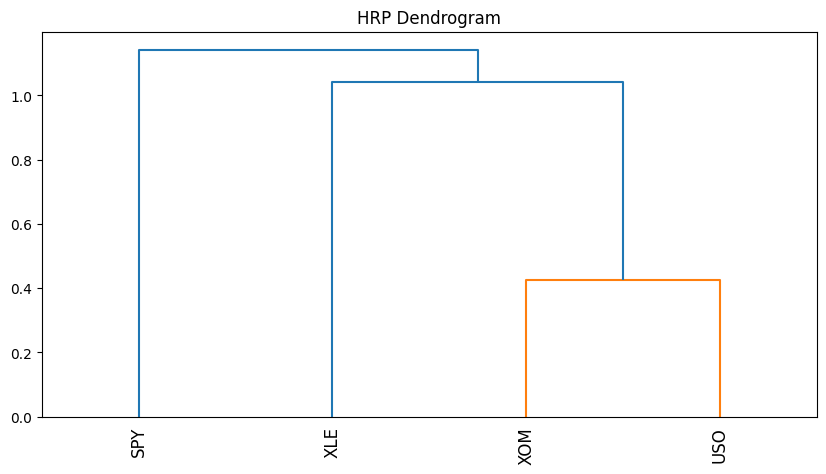

In [16]:
linkage = get_linkage_matrix(cov)
plt.figure(figsize=(10, 5))
sch.dendrogram(linkage, labels=tickers, leaf_rotation=90)
plt.title("HRP Dendrogram")
plt.show()

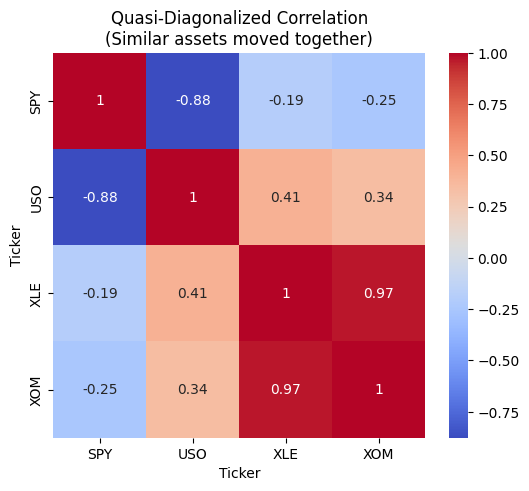

In [17]:
sort_ix = get_quasi_diag(linkage)
sort_tickers = cov.index[sort_ix].tolist()
cov_sorted = cov.loc[sort_tickers, sort_tickers]

plt.figure(figsize=(6,5))
sns.heatmap(cov_sorted.corr(), cmap='coolwarm', annot=True)
plt.title("Quasi-Diagonalized Correlation\n(Similar assets moved together)")
plt.show()

     IVP (Naive)  HRP (Smart)
SPY         0.37         0.59
USO         0.18         0.13
XLE         0.22         0.13
XOM         0.23         0.15


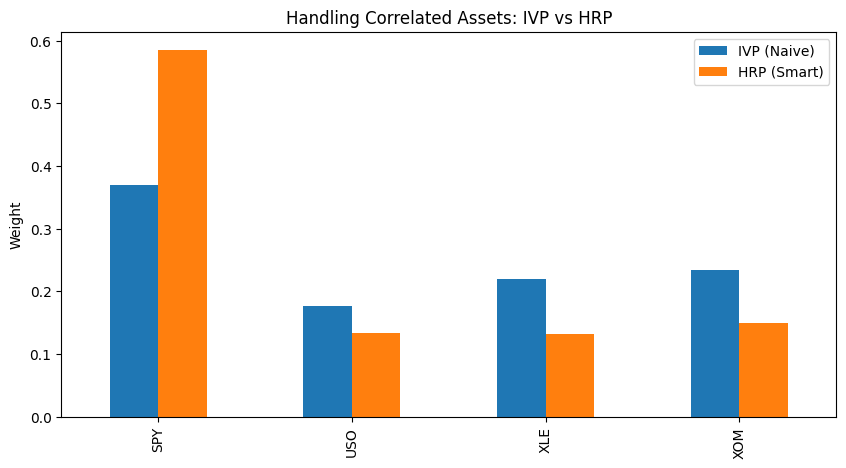

In [18]:
w_hrp = get_hrp_weights(cov)

# Calculate naive IVP for comparison
ivp_vol = 1 / np.sqrt(np.diag(cov))
w_ivp = pd.Series(ivp_vol / ivp_vol.sum(), index=cov.columns)

results = pd.DataFrame({'IVP (Naive)': w_ivp, 'HRP (Smart)': w_hrp})
print(results.round(2))

# Plot
results.plot(kind='bar', figsize=(10, 5), title="Handling Correlated Assets: IVP vs HRP")
plt.ylabel("Weight")
plt.show()